In [1]:
import tensorflow as tf
import numpy as np

def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

In [2]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [3]:
# loading the dataset tf.examples.tutorials.mnist is depreciated

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28 *28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/ 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

## Vanishing/exploding gradients problem

In [4]:
reset_graph()

def logit(z):
    return 1/ (1 + np.exp(-z))

In [5]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5,5,200)

plt.plot([-5,-5], [0,0], 'k-')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0,0], [-0.2,1.2], 'k-')
plt.plot([-5,5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props= dict(facecolor='black',shrink=0.1)

plt.annotate('Saturating', xytext=(3.5,0.7), xy=(5,1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5,0.3), xy=(-5,0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5),arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

<Figure size 640x480 with 1 Axes>

### Xavier and He Initialisation

In [6]:
# The book uses fully_connected isntaead of dense but it is preferable to use dense

import tensorflow as tf

#reset_graph()
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 *28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [7]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

W0530 10:39:02.405937 13420 deprecation.py:323] From <ipython-input-7-da109dac52d3>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0530 10:39:02.410925 13420 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


### Non Saturating Activation function

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

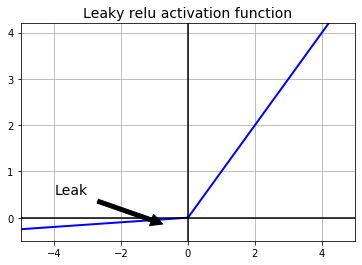

In [9]:
# plotting leaky relu

plt.plot(z, leaky_relu(z, 0.05), "b-",linewidth=2)
plt.plot([-5,5],[0,0], 'k-')
plt.plot([0,0], [-0.5, 4.2],'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)

plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-0.5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky relu activation function", fontsize=14)
plt.axis([-5,5,-0.5,4.2])

plt.show()

### Implementing leaky relu in tensorflow

In [10]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")

In [11]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [12]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [13]:
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [14]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [15]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [16]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

W0530 10:39:21.877292 13420 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
# loading the dataset tf.examples.tutorials.mnist is depreciated

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28 *28)/ 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28)/ 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [20]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [21]:
n_epochs = 40
batch_size =50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
            print(epoch, acc_batch, acc_valid)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 0.86 0.9048
5 0.94 0.9496
10 0.92 0.9656
15 0.94 0.9714
20 1.0 0.9762
25 1.0 0.9774
30 0.98 0.978
35 1.0 0.9786


### ELU function

In [22]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

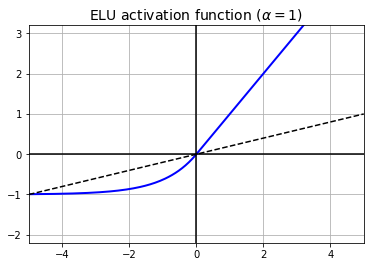

In [23]:
plt.plot(z, elu(z),"b-", linewidth=2)
plt.plot([-5,5], [0,0], 'k-')
plt.plot([-5,5], [-1,1], 'k--')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5,5,-2.2,3.2])

plt.show()

In [24]:
import tensorflow as tf
import numpy as np

def reset_graph():

    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

In [25]:
# implementing ELU in tensorflow
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [26]:
hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.elu, name="hidden1")

### SELU

In [32]:
# this function tends to preserve the same mean and variance 
# during training of every layer
# During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function 
# and LeCun initialization will self-normalize
# In practice it works very well with CNN

# unfortunately you canot yse l1 or l2 regularisation

from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [33]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

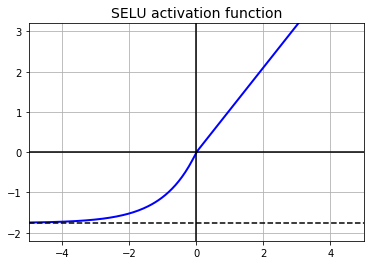

In [35]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

# the selu function hyperparameters are tuned in such a way that mean output of each
# neiron remains close to 0 
# and the standrd deviation remains close to 1
# even if therewere about 1000 layers

In [36]:
# we can verify for 1000 layers

np.random.seed(42)
Z = np.random.normal(size=(500,100))
for layer in range(1000):
    W = np.random.normal(size=(100,100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("layer: ", layer,"mean: ", means,"deviation: ", stds)

layer:  0 mean:  -0.0018323191229082014 deviation:  0.9993326848140984
layer:  100 mean:  0.022381401728658136 deviation:  0.9624307594850072
layer:  200 mean:  0.009595136169400975 deviation:  0.9044881262732755
layer:  300 mean:  -0.01519457019486652 deviation:  0.9236924543338241
layer:  400 mean:  0.0541343380033697 deviation:  0.8916028369516269
layer:  500 mean:  0.005853113458524639 deviation:  0.9286462949083308
layer:  600 mean:  0.022268641456820597 deviation:  0.9166416040576405
layer:  700 mean:  -0.01825907594144632 deviation:  0.9033554369309249
layer:  800 mean:  0.053814955568643616 deviation:  0.8250223490618902
layer:  900 mean:  0.01989578336047298 deviation:  0.9952796987739755


In [37]:
# selufunction for tensorflow<1.14

def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z>=0.0, z,alpha*tf.nn.elu(z))

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [39]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X:X_batch_scaled, y:y_batch})
        if epoch % 5 ==0:
            acc_batch = accuracy.eval(feed_dict={X:X_batch_scaled, y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X:X_val_scaled, y:y_valid})
            print(epoch, "Batch accurac: ", acc_batch, "validation accuracy: ", acc_valid)
    
    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accurac:  0.94 validation accuracy:  0.9388
5 Batch accurac:  0.98 validation accuracy:  0.9634
10 Batch accurac:  1.0 validation accuracy:  0.9694
15 Batch accurac:  1.0 validation accuracy:  0.9704
20 Batch accurac:  1.0 validation accuracy:  0.9692
25 Batch accurac:  1.0 validation accuracy:  0.9692
30 Batch accurac:  1.0 validation accuracy:  0.9708
35 Batch accurac:  1.0 validation accuracy:  0.9706



### Batch Normalisation

In [40]:
import tensorflow as tf
import numpy as np

reset_graph()

from tensorflow.contrib.layers import batch_norm

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")

# decay is renamed as momentum
# is_training parameter would either be true or false
# tells what means to be used in testing ans trainaing phase
# in testing we need to use the entire dataset mean and standard deviation

#is_training = tf.placeholder(tf.bool,shape=(), name="is training")

training = tf.placeholder_with_default(False, shape=(), name='training')

# bn_params is a dictionary that defines the parameters that will be passed to batch norm()
# algorithm uses exponential decay to compute the running averages
# a good decay is close to one
# Update collection to be set to None if we want the batch_norm()
# function to update the running averages right before it perform
#batch normalisation during training

# bn_params = {
#     "is_training" : is_training,
#     "decay": 0.99,
#     "updates_collections": None
# }

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.90)  
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2,name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

# normalizer_fn = batch_norm, normalizer_params=bn_params)
# hidden2 = dense(hidden1, n_hidden2 , scope="hidden2",
#                 normalizer_fn =batch_norm, normalizer_paramas=bn_params)
# logits = dense(hidden2, n_outputs,activation_fn=None, scope="outputs",
#                normalizer_fn =batch_norm, normalizer_params=bn_params)



W0530 11:24:38.453265 13420 deprecation.py:323] From <ipython-input-40-dd5d141516b5>:38: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [41]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
training = tf.placeholder_with_default(False,shape=(), name="training")

In [42]:
# to avoid repeating the same function again and again we can call the partil function

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.90)

hidden1 = tf.layers.dense(X,n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act,n_hidden2,name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [43]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_epochs = 20
batch_size = 200

In [45]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training:True, X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    save_path = saver.save(sess, "./my_model_final.ckpt")

# its not great accuracy for mnist
# butwe can get better result if we train it for longer


0 Validation accuracy:  0.8952
1 Validation accuracy:  0.9202
2 Validation accuracy:  0.9318
3 Validation accuracy:  0.9422
4 Validation accuracy:  0.9468
5 Validation accuracy:  0.954
6 Validation accuracy:  0.9568
7 Validation accuracy:  0.96
8 Validation accuracy:  0.962
9 Validation accuracy:  0.9638
10 Validation accuracy:  0.9662
11 Validation accuracy:  0.9682
12 Validation accuracy:  0.9672
13 Validation accuracy:  0.9696
14 Validation accuracy:  0.9706
15 Validation accuracy:  0.9704
16 Validation accuracy:  0.9718
17 Validation accuracy:  0.9726
18 Validation accuracy:  0.9738
19 Validation accuracy:  0.9742


In [46]:
# we can make the training operation depend on the update operations
# with tf.name_scope("Train"):
#  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(extra_update_ops):
#  training_op = optimizer.minimize(loss)
# the during sess.run when training_op is called the tensorflow will aitomatically run update as well

#looking at the trainable variable

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [41]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### Gradient clipping for MNIST

In [47]:
reset_graph()


# we are using extra layers to demonstrate using pretrained models
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    

In [48]:
learning_rate =0.01

In [49]:
# we apply clip by value()

threshold = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [53]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k (logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),name="accuracy" )

In [54]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [55]:
n_epochs = 20
batch_Size =200

In [56]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy:  0.288
1 validation accuracy:  0.794
2 validation accuracy:  0.8796
3 validation accuracy:  0.9058
4 validation accuracy:  0.9164
5 validation accuracy:  0.9222
6 validation accuracy:  0.929
7 validation accuracy:  0.9356
8 validation accuracy:  0.938
9 validation accuracy:  0.9416
10 validation accuracy:  0.946
11 validation accuracy:  0.9472
12 validation accuracy:  0.9474
13 validation accuracy:  0.9534
14 validation accuracy:  0.9566
15 validation accuracy:  0.9566
16 validation accuracy:  0.9578
17 validation accuracy:  0.9586
18 validation accuracy:  0.9622
19 validation accuracy:  0.9616


### Reusing a TensorFlow model

In [57]:
reset_graph()

In [58]:

# we will first load the meta file

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [60]:
# we need a handle on all the operations we need for the training.

for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [61]:
#from tensorflow_graph_in_jupyter import show_graph
# need to define this firts

In [62]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [63]:
# another approach
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops",op)

In [64]:
# such that
X,y, accuracy,training_op=tf.get_collection("my_important_ops")

In [65]:
# starting a session
# restoring model state 
# training on our data

with tf.Session() as sess:
    saver.restore(sess, "my_model_final.ckpt")

In [66]:
# testing

n_epochs = 20
batch_size =200

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch, in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy", accuracy_val)
    
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 validation accuracy 0.9644
1 validation accuracy 0.9628
2 validation accuracy 0.9654
3 validation accuracy 0.9652
4 validation accuracy 0.9642
5 validation accuracy 0.965
6 validation accuracy 0.9686
7 validation accuracy 0.9686
8 validation accuracy 0.9682
9 validation accuracy 0.9688
10 validation accuracy 0.97
11 validation accuracy 0.9716
12 validation accuracy 0.9672
13 validation accuracy 0.97
14 validation accuracy 0.971
15 validation accuracy 0.9724
16 validation accuracy 0.9718
17 validation accuracy 0.9714
18 validation accuracy 0.9712
19 validation accuracy 0.971


In [67]:
# now we need to reuse only the lower layers
# in this example we add a new 4th layer on top of a third layer
#we will also build a new output layer the loss of this new output and an optimiser to minimise it
# and then we save the new graph and an initilisation up

reset_graph()

n_hidden4 = 20
n_outputs = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits,y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [68]:
# training the new model

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
        
        save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy:  0.916
1 Validation accuracy:  0.932
2 Validation accuracy:  0.9446
3 Validation accuracy:  0.947
4 Validation accuracy:  0.9498
5 Validation accuracy:  0.9534
6 Validation accuracy:  0.9542
7 Validation accuracy:  0.9562
8 Validation accuracy:  0.9602
9 Validation accuracy:  0.9586
10 Validation accuracy:  0.9626
11 Validation accuracy:  0.9622
12 Validation accuracy:  0.9602
13 Validation accuracy:  0.9652
14 Validation accuracy:  0.9648
15 Validation accuracy:  0.9668
16 Validation accuracy:  0.9656
17 Validation accuracy:  0.967
18 Validation accuracy:  0.9674
19 Validation accuracy:  0.9668


In [69]:
# we can reuse the parts we need in the old python code
reset_graph()

n_inputs = 28 * 28 #MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4,n_outputs, name="outputs") 

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [70]:
# we have to create one Saver to restore the pretrained moodel
# and another saver for new model

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]")# regex to get layers 1 to 3
restore_saver = tf.train.Saver(reuse_vars) # restore layer 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict = {X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy:  0.9022
1 Validation accuracy:  0.933
2 Validation accuracy:  0.943
3 Validation accuracy:  0.947
4 Validation accuracy:  0.952
5 Validation accuracy:  0.9534
6 Validation accuracy:  0.9556
7 Validation accuracy:  0.959
8 Validation accuracy:  0.9588
9 Validation accuracy:  0.9606
10 Validation accuracy:  0.9622
11 Validation accuracy:  0.9622
12 Validation accuracy:  0.9638
13 Validation accuracy:  0.9658
14 Validation accuracy:  0.9662
15 Validation accuracy:  0.9662
16 Validation accuracy:  0.9672
17 Validation accuracy:  0.9672
18 Validation accuracy:  0.9682
19 Validation accuracy:  0.9674


### Reusing models from other frameworks

In [71]:
# following code shows how you would copy the weight and biases from the 
# first hidden layer of  a model tranined using another framework

reset_graph()
n_inputs = 2
n_hidden1 = 3

In [72]:
original_w = [[1.,2.,3.], [4.,5.,6.]] # weights from the other framework
original_b = [7.,8.,9.] # loading the biases fromother frameworks

X= tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")

graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel:original_w, init_bias: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0,11.0]]}))
    

[[ 61.  83. 105.]]


In [73]:
# the book uses a more verbose version

reset_graph()

n_inputs =2
n_hidden1 = 3

original_w = [[1.,2.,3.], [4.,5.,6.]]
original_b = [7.,8.,9.]

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name="X")
hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.relu, name="hidden1")


with tf.variable_scope("", default_name="", reuse=True):
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# creating dedicated placeholder and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights,feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    print(hidden1.eval(feed_dict={X: [[10.0,11.0]]}))
    

[[ 61.  83. 105.]]


In [74]:
# we could have gtten the handle iusin getcollection and specifying scope
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")


[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [75]:
#or the get_tensor_by_name() method
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [76]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the lower layers

In [77]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1" )
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits  = tf.layers.dense(hidden4, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),name="accuracy")

In [78]:
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope = "hidden[34]| outputs")
    training_op = optimizer.minimize(loss, var_list = train_vars)

In [79]:
n_epochs = 20
batch_size = 200

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

0 Validation accuracy:  0.7462
1 Validation accuracy:  0.8754
2 Validation accuracy:  0.9056
3 Validation accuracy:  0.9168
4 Validation accuracy:  0.9234
5 Validation accuracy:  0.9282
6 Validation accuracy:  0.9336
7 Validation accuracy:  0.9354
8 Validation accuracy:  0.9364
9 Validation accuracy:  0.9398
10 Validation accuracy:  0.9398
11 Validation accuracy:  0.9418
12 Validation accuracy:  0.9426
13 Validation accuracy:  0.9442
14 Validation accuracy:  0.946
15 Validation accuracy:  0.9458
16 Validation accuracy:  0.948
17 Validation accuracy:  0.9478
18 Validation accuracy:  0.9498
19 Validation accuracy:  0.9464


### faster optimizers

In [80]:
## momentum 
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

# Nestrov Accelerated Gradient
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                      momentum=0.9,use_nesterov=True)

#AdaGrad
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

#RMS_prop
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10 )

In [81]:
# Adam optimisation

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Learning rate scheduling

In [82]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [83]:
with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                               global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [84]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [85]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy: ", accuracy_val)
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy:  0.9566
1 validation accuracy:  0.9724
2 validation accuracy:  0.9764
3 validation accuracy:  0.9784
4 validation accuracy:  0.9838


### l1 and l2 regularisation

In [7]:
# manual implementation

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_outputs =10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [8]:
# next we get a handle on layer weights and then compute thte total loss which
# is equal to the usal cros entropy loss and the l1 loss computed on
# the absolute value of weights

W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [9]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy= tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
n_epochs = 20
batch_size =200
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "validation accuracy: ", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy:  0.831
1 validation accuracy:  0.871
2 validation accuracy:  0.8838
3 validation accuracy:  0.8934
4 validation accuracy:  0.8966
5 validation accuracy:  0.8988
6 validation accuracy:  0.9016
7 validation accuracy:  0.9044
8 validation accuracy:  0.9058
9 validation accuracy:  0.906
10 validation accuracy:  0.9068
11 validation accuracy:  0.9054
12 validation accuracy:  0.907
13 validation accuracy:  0.9084
14 validation accuracy:  0.9088
15 validation accuracy:  0.9064
16 validation accuracy:  0.9066
17 validation accuracy:  0.9066
18 validation accuracy:  0.9066
19 validation accuracy:  0.9052


In [17]:
# Alternatively we can pass regularisation function to the tf.layers.dense()

reset_graph()
n_inputs=28 *28
n_hidden1 =300
n_hidden2 =50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# we will use the Pythons partial function to avoid repeating same arguments
from functools import partial

# kernel regulariser argumetn 
scale =0.001

In [18]:


my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)
)

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                           name="outputs")

In [20]:
# regularisation loss

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels =y, logits=logits
    )
    base_loss= tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [22]:
with tf.name_scope("eval"):
    # what is this
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate =0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size =200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
        print(epoch, "Validation accuracy: ", accuracy_val)
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy:  0.8274
1 Validation accuracy:  0.8766
2 Validation accuracy:  0.8952
3 Validation accuracy:  0.9016
4 Validation accuracy:  0.908
5 Validation accuracy:  0.9096
6 Validation accuracy:  0.9124
7 Validation accuracy:  0.9154
8 Validation accuracy:  0.9178
9 Validation accuracy:  0.919
10 Validation accuracy:  0.92
11 Validation accuracy:  0.9224
12 Validation accuracy:  0.9212
13 Validation accuracy:  0.9228
14 Validation accuracy:  0.9222
15 Validation accuracy:  0.9218
16 Validation accuracy:  0.9218
17 Validation accuracy:  0.9228
18 Validation accuracy:  0.9216
